Pypsa model

In [1]:
import pypsa
import geopandas as gpd
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import gurobipy

In [2]:
wind_onshore_df = pd.read_csv('data/wind_onshore.csv')
wind_offshore_df = pd.read_csv('data/wind_offshore.csv')
pv_df = pd.read_csv('data/pv_df.csv')

load_df = pd.read_csv('data/load_final.csv')


merged_gdf=gpd.read_file('data/merged_gdf.gpkg')
merged_points=gpd.read_file('data/merged_gdf_mittelpunkte.gpkg') # indezierung 1-6 entspricht regionen 1-7
merged_gdf['ref_point'] = merged_points.loc[merged_gdf.index]
kraftwerke=pd.read_csv('data/kraftwerke.csv')
technology=pd.read_csv('data/Technology.csv', delimiter=';') # techdata ist gerade noch platzhalter
kraftwerke=kraftwerke[(kraftwerke['primary_fuel']!= 'Solar')& (kraftwerke['primary_fuel'] !='Wind')][['merge_category','primary_fuel',  'capacity_mw']]


# print(kraftwerke)

In [3]:
# resample 
print(load_df)
print(wind_offshore_df)
#ts = ts.resample(f"{resolution}h").first()

load_df.index = pd.to_datetime(load_df.index)
wind_offshore_df.index = pd.to_datetime(wind_offshore_df.index)
wind_onshore_df.index = pd.to_datetime(wind_onshore_df.index)
pv_df.index = pd.to_datetime(pv_df.index)


resolution = 4

load_df = load_df.resample(f"{resolution}h").first()
wind_offshore_df = wind_offshore_df.resample(f"{resolution}h").first()
wind_onshore_df = wind_onshore_df.resample(f"{resolution}h").first()
pv_df = pv_df.resample(f"{resolution}h").first()


load_df

                              KR      region_1     region_2      region_3  \
2013-01-01 00:00:00  98799.47963  50691.306163  2734.877749  11577.230408   
2013-01-01 01:00:00  98108.53821  50336.803051  2715.751734  11496.266540   
2013-01-01 02:00:00  98099.29047  50332.058289  2715.495746  11495.182898   
2013-01-01 03:00:00  97973.01460  50267.269599  2712.000292  11480.386010   
2013-01-01 04:00:00  98043.15384  50303.256122  2713.941823  11488.604861   
...                          ...           ...          ...           ...   
2013-12-31 19:00:00  81062.67877  41591.039582  2243.903685   9498.848710   
2013-12-31 20:00:00  85450.24847  43842.181387  2365.356417  10012.980014   
2013-12-31 21:00:00  90283.60701  46322.045234  2499.149073  10579.348437   
2013-12-31 22:00:00  94711.94733  48594.105327  2621.730380  11098.257205   
2013-12-31 23:00:00  97979.23475  50270.460988  2712.172473  11481.114882   

                        region_4     region_5      region_6     region_7  


,KR,region_1,region_2,region_3,region_4,region_5,region_6,region_7
2013-01-01 00:00:00,98799.47963,50691.306163,2734.877749,11577.230408,8928.714439,3028.398138,13381.929654,7374.820961
2013-01-01 04:00:00,98043.15384,50303.256122,2713.941823,11488.604861,8860.363704,3005.215267,13279.488846,7318.365529
2013-01-01 08:00:00,101776.08900,52218.522880,2817.273555,11926.026703,9197.716818,3119.637063,13785.097538,7597.007973
2013-01-01 12:00:00,95766.00586,49134.913881,2650.907874,11221.770795,8654.573106,2935.416208,12971.059751,7148.389344
2013-01-01 16:00:00,84174.84570,43187.807169,2330.051873,9863.529513,7607.055857,2580.124379,11401.091058,6283.174960
...,...,...,...,...,...,...,...,...
2013-12-31 04:00:00,90073.37365,46214.180256,2493.329583,10554.713489,8140.118094,2760.925848,12200.019214,6723.466627
2013-12-31 08:00:00,90604.61923,46486.747809,2508.035042,10616.964348,8188.127862,2777.209568,12271.973955,6763.121097
2013-12-31 12:00:00,89034.85095,45681.342712,2464.582138,10433.020372,8046.264638,2729.093087,12059.356148,6645.946796
2013-12-31 16:00:00,81636.87832,41885.645639,2259.798157,9566.132875,7377.694467,2502.330693,11057.335190,6093.730085


In [4]:

# Vereinheitlichung der Carrier-Namen
kraftwerke['primary_fuel'] = kraftwerke['primary_fuel'].replace({
    "Coal": "coal",
    "Gas": "LNG",
    "Hydro": "hydro",
    "Oil": "oil",
    "Waste": "waste CHP",
    "Biomass": "biomass",
    "Nuclear": "nuclear"
})

In [5]:
# 3965 Gwh/a from 2022 :   https://www.irena.org/-/media/Files/IRENA/Agency/Statistics/Statistical_Profiles/Asia/Republic%20of%20Korea_Asia_RE_SP.pdf
# selbe quelle sagt capacity factor von 22% 
anual_hydro_mwh=3965000 
hydro_cap_mw= kraftwerke[kraftwerke['primary_fuel']=='hydro']['capacity_mw'].sum()   

capcity_factor_Hydro= anual_hydro_mwh/(hydro_cap_mw*8760)
hydro_df= pv_df.copy()
hydro_df[:]=capcity_factor_Hydro   # capacity factor mit production zeitreihe für jede region in eigene (konstante) Zeitreihe umwandeln 

In [6]:
# Initialize model  and ad buses 
n = pypsa.Network()
n.snapshots=load_df.index


In [7]:


n.add("Bus", "region_1", y=merged_gdf.ref_point.y[0], x=merged_gdf.ref_point.x[0], carrier="AC")
n.add("Bus", "region_2", y=merged_gdf.ref_point.y[1], x=merged_gdf.ref_point.x[1], carrier="AC")
n.add("Bus", "region_3", y=merged_gdf.ref_point.y[2], x=merged_gdf.ref_point.x[2], carrier="AC")
n.add("Bus", "region_4", y=merged_gdf.ref_point.y[3], x=merged_gdf.ref_point.x[3], carrier="AC")
n.add("Bus", "region_5", y=merged_gdf.ref_point.y[4], x=merged_gdf.ref_point.x[4], carrier="AC")
n.add("Bus", "region_6", y=merged_gdf.ref_point.y[5], x=merged_gdf.ref_point.x[5], carrier="AC")
n.add("Bus", "region_7", y=merged_gdf.ref_point.y[6], x=merged_gdf.ref_point.x[6], carrier="AC") #y=-30.5, x=25, v_nom=400, carrier="AC")

#eigentlich wäre eine Einheitlichere Darstekkzbf besser jedoch werden die merged points nicht am richtigen Punkt angezeigt ich vermute es liegt am EPSG

# n.add("Bus", "region_1", y=merged_points.iloc[0].geometry.y, x=merged_points.iloc[0].geometry.y)# v_nom=400, carrier="AC")
# n.add("Bus", "region_2", y=merged_points.iloc[1].geometry.y, x=merged_points.iloc[1].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")
# n.add("Bus", "region_3", y=merged_points.iloc[2].geometry.y, x=merged_points.iloc[2].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")
# n.add("Bus", "region_4", y=merged_points.iloc[3].geometry.y, x=merged_points.iloc[3].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")
# n.add("Bus", "region_5", y=merged_points.iloc[4].geometry.y, x=merged_points.iloc[4].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")
# n.add("Bus", "region_6", y=merged_points.iloc[5].geometry.y, x=merged_points.iloc[5].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")
# n.add("Bus", "region_7", y=merged_points.iloc[6].geometry.y, x=merged_points.iloc[6].geometry.y) #y=-30.5, x=25, v_nom=400, carrier="AC")

Index(['region_7'], dtype='object')

In [8]:
# Carrier

# Liste der betrachteten Technologien
carriers = [
    "AC",
    "onwind",
    "offwind",
    "solar",
    #"gas",
    "biomass",
    "coal",
    "nuclear",
    #"ror",
    "oil",
    "hydrogen storage underground",
    "battery inverter",
    "battery storage",
    "electrolysis",
    "fuel cell",
    "LNG",
    "waste CHP",
    "hydro"
]

# Farbzuteilung für die Carrier
carrier_colors = {
    "AC": "yellow",
    "onwind": "dodgerblue",
    "offwind": "aquamarine",
    "solar": "gold",
    #"gas": "indianred",
    "biomass": "green",
    "coal": "black",
    "nuclear": "darkviolet",
    #"ror": "deepskyblue",
    "oil": "brown",
    "hydrogen storage underground": "cyan",
    "battery inverter": "darkorange",
    "battery storage": "yellowgreen",
    "electrolysis": "royalblue",
    "fuel cell": "limegreen",
    "LNG": "grey",
    "waste CHP": "chocolate",
    "hydro": "mediumblue"
}

In [9]:
# LNG Daten hnzufügen
"""
# Lade die bestehende CSV-Datei
file_path = 'data/costs_2050.csv'
costs_df = pd.read_csv(file_path)

# Neue LNG-Daten als DataFrame
data_to_add = pd.DataFrame({
    "technology": ["LNG", "LNG", "LNG", "LNG"],
    "parameter": ["fuel", "efficiency", "VOM", "CO2 intensity"],
    "value": [43.58, 0.94, 1.007, 0.198],
    "unit": ["EUR/MWh_th", "per unit", "EUR/MWh", "tCO2/MWh_th"],
    "source": [
        "https://www.cmegroup.com/markets/energy/natural-gas/lng-japan-korea-marker-platts-swap.quotes.options.html?utm_source=chatgpt.com#optionProductId=8571",
        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",
        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",
        "Stoichiometric calculation with 50 GJ/t CH4"
    ],
    "currency_year": [2024.0, None, 2019.0, None]
})

# Daten an die bestehende CSV-Datei anhängen
updated_costs_df = pd.concat([costs_df, data_to_add], ignore_index=True)

# Aktualisierte Datei speichern
updated_costs_df.to_csv(file_path, index=False)

print("LNG-Daten wurden erfolgreich hinzugefügt und gespeichert.")
"""

'\n# Lade die bestehende CSV-Datei\nfile_path = \'data/costs_2050.csv\'\ncosts_df = pd.read_csv(file_path)\n\n# Neue LNG-Daten als DataFrame\ndata_to_add = pd.DataFrame({\n    "technology": ["LNG", "LNG", "LNG", "LNG"],\n    "parameter": ["fuel", "efficiency", "VOM", "CO2 intensity"],\n    "value": [43.58, 0.94, 1.007, 0.198],\n    "unit": ["EUR/MWh_th", "per unit", "EUR/MWh", "tCO2/MWh_th"],\n    "source": [\n        "https://www.cmegroup.com/markets/energy/natural-gas/lng-japan-korea-marker-platts-swap.quotes.options.html?utm_source=chatgpt.com#optionProductId=8571",\n        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",\n        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",\n        "Stoichiometric calculation with 50 GJ/t CH4"\n    ],\n    "currency_year": [2024.0, None, 2019.0, None]\n})\n\n# Daten an die bestehende CSV-Datei anhängen\nupdated_costs_df = pd.concat([costs_df, data_to_add], ignore_index=True)\n\n# Aktualisierte

In [10]:
# Hydrogen Import Daten hinzufügen
"""
# Lade die bestehende CSV-Datei
file_path = 'data/costs_2050.csv'
costs_df = pd.read_csv(file_path)

# Neue LNG-Daten als DataFrame
data_to_add = pd.DataFrame({
    "technology": ["hydrogen gas power plant", "hydrogen gas power plant", "hydrogen gas power plant", "hydrogen gas power plant"],
    "parameter": ["fuel", "efficiency", "VOM", "CO2 intensity"],
    "value": [50.10, 0.94, 2.007, 0],
    "unit": ["EUR/MWh_th", "per unit", "EUR/MWh", "tCO2/MWh_th"],
    "source": [
        "https://www.spglobal.com/commodity-insights/en/news-research/latest-news/energy-transition/112621-s-korea-to-provide-279-mil-mtyear-of-clean-hydrogen-by-2050",
        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",
        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx, verdoppelt für Wasserstoff",
        "."
    ],
    "currency_year": [2025.0, None, 2019.0, None]
})

# Daten an die bestehende CSV-Datei anhängen
updated_costs_df = pd.concat([costs_df, data_to_add], ignore_index=True)

# Aktualisierte Datei speichern
updated_costs_df.to_csv(file_path, index=False)

print("Hydrogen-Daten wurden erfolgreich hinzugefügt und gespeichert.")
"""


'\n# Lade die bestehende CSV-Datei\nfile_path = \'data/costs_2050.csv\'\ncosts_df = pd.read_csv(file_path)\n\n# Neue LNG-Daten als DataFrame\ndata_to_add = pd.DataFrame({\n    "technology": ["hydrogen gas power plant", "hydrogen gas power plant", "hydrogen gas power plant", "hydrogen gas power plant"],\n    "parameter": ["fuel", "efficiency", "VOM", "CO2 intensity"],\n    "value": [50.10, 0.94, 2.007, 0],\n    "unit": ["EUR/MWh_th", "per unit", "EUR/MWh", "tCO2/MWh_th"],\n    "source": [\n        "https://www.spglobal.com/commodity-insights/en/news-research/latest-news/energy-transition/112621-s-korea-to-provide-279-mil-mtyear-of-clean-hydrogen-by-2050",\n        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx",\n        "Danish Energy Agency, technology_data_for_industrial_process_heat.xlsx, verdoppelt für Wasserstoff",\n        "."\n    ],\n    "currency_year": [2025.0, None, 2019.0, None]\n})\n\n# Daten an die bestehende CSV-Datei anhängen\nupdated_costs_df =

In [11]:
# Calculate costs & technology data


costs_df = pd.read_csv('data/costs_2050.csv')


# Berechnung der Annuität
def annuity(r, n):
    return r / (1 - (1 + r) ** -n)

# Diskontsatz definieren
discount_rate = 0.07

# Filtere die relevanten Technologien aus der CSV-Datei
filtered_costs_df = costs_df[costs_df["technology"].isin(carriers)]

# Liste zur Speicherung der berechneten Kosten
calculated_costs = []

# Berechnungen für jede Technologie durchführen
for technology in filtered_costs_df["technology"].unique():
    tech_data = filtered_costs_df[filtered_costs_df["technology"] == technology]

    # Extrahiere Parameter
    investment = tech_data.loc[tech_data["parameter"] == "investment", "value"].values
    fom = tech_data.loc[tech_data["parameter"] == "FOM", "value"].values
    vom = tech_data.loc[tech_data["parameter"] == "VOM", "value"].values
    fuel = tech_data.loc[tech_data["parameter"] == "fuel", "value"].values
    efficiency = tech_data.loc[tech_data["parameter"] == "efficiency", "value"].values
    lifetime = tech_data.loc[tech_data["parameter"] == "lifetime", "value"].values
    co2_intensity = tech_data.loc[tech_data["parameter"] == "CO2 intensity", "value"].values

    # Standardwerte setzen, falls Parameter fehlen
    investment = investment[0] if investment.size > 0 else 0
    fom = fom[0] if fom.size > 0 else 0
    vom = vom[0] if vom.size > 0 else 0
    fuel = fuel[0] if fuel.size > 0 else 0
    efficiency = efficiency[0] if efficiency.size > 0 else 1
    lifetime = lifetime[0] if lifetime.size > 0 else 25
    co2_intensity = co2_intensity[0] if co2_intensity.size > 0 else 0

    # Berechnung der Annuität
    annuity_value = annuity(discount_rate, lifetime)

    # Berechnung der Grenzkosten (Marginal Cost)
    marginal_cost = fuel / efficiency + vom

    # Berechnung der Kapital-Kosten (Capital Cost)
    capital_cost = investment * 1000 * annuity_value + ((fom / 100) * investment * 1000)

    # Ergebnisse speichern
    calculated_costs.append(
        {
            "technology": technology,
            "marginal_cost": marginal_cost,
            "capital_cost": capital_cost,
            "efficiency": efficiency,
            "co2_intensity": co2_intensity,  # CO2-Intensität hinzufügen
        }
    )

# Ergebnisse in einen DataFrame umwandeln
calculated_costs_df = pd.DataFrame(calculated_costs)


calculated_costs_df

,technology,marginal_cost,capital_cost,efficiency,co2_intensity
0,battery inverter,0.000000,9611.457194,0.9600,0.0000
1,battery storage,0.000000,6395.868853,1.0000,0.0000
2,biomass,15.828205,294201.051170,0.4680,0.0000
3,coal,30.098840,337208.027448,0.3560,0.3361
4,electrolysis,0.000000,125810.517221,0.6994,0.0000
5,fuel cell,0.000000,162862.426840,0.5000,0.0000
6,hydro,0.000000,182698.734592,0.9000,0.0000
7,hydrogen storage underground,0.000000,88.995563,1.0000,0.0000
8,nuclear,14.013271,753784.215297,0.3260,0.0000
9,offwind,0.021200,155808.854518,1.0000,0.0000


In [12]:
# Füge Carrier mit Farben und CO2-Intensität hinzu
"""
n.add(
    "Carrier",
    carriers,
    color=[carrier_colors[c] for c in carriers],  # Farbe für jeden Carrier zuweisen
    co2_emissions = [
    calculated_costs_df.loc[c, "co2_intensity"] if c in calculated_costs_df.index else None
    for c in carriers
]
)
"""

n.add(
    "Carrier",
    carriers,
    color=[carrier_colors.get(c, "#000000") for c in carriers],  # Falls kein Farbwert existiert, Standardfarbe setzen
    co2_emissions=[
        calculated_costs_df.loc[calculated_costs_df["technology"] == c, "co2_intensity"].fillna(0).values[0]
        if (calculated_costs_df["technology"] == c).any() else 0  
        for c in carriers
    ]
)



Index(['AC', 'onwind', 'offwind', 'solar', 'biomass', 'coal', 'nuclear', 'oil',
       'hydrogen storage underground', 'battery inverter', 'battery storage',
       'electrolysis', 'fuel cell', 'LNG', 'waste CHP', 'hydro'],
      dtype='object')

In [13]:
regions=['region_1','region_2','region_3','region_4','region_5','region_6','region_7']
techs=['solar','wind_offshore','wind_onshore']
potential_per_region = pd.read_csv("data/capacity_per_region_hotfix.csv", index_col=0)


In [14]:
#hotfix für carriere mismatch 
def carrier_match(a):
    if a=='solar':
        return 'solar'
    elif a== 'wind_offshore':
        return "offwind"
    elif a== 'wind_onshore':
        return "onwind"


In [15]:
tech_data = {
    "solar": pv_df,
    "wind_onshore": wind_onshore_df,
    "wind_offshore": wind_offshore_df,
    "hydro": hydro_df
}

In [16]:
# add renewables generators

for region in regions:
    for tech in techs:
        n.add(
            f"Generator",
            f" Generator {region}, {tech}",
            carrier=carrier_match(tech),
            bus=region, 
            p_max_pu=tech_data[tech][region], #
            p_nom_extendable=True,
            p_nom_max=potential_per_region.at[region, tech],
            capital_cost=calculated_costs_df.set_index('technology')['capital_cost'].get(carrier_match(tech)),
            marginal_cost=calculated_costs_df.set_index('technology')['marginal_cost'].get(carrier_match(tech)),
            efficiency=calculated_costs_df.set_index('technology')['efficiency'].get(carrier_match(tech)),
              )
        

# n.loads_t

n.generators.marginal_cost
n.generators.capital_cost

Generator
Generator region_1, solar             39108.181179
Generator region_1, wind_offshore    155808.854518
Generator region_1, wind_onshore      94128.969871
Generator region_2, solar             39108.181179
Generator region_2, wind_offshore    155808.854518
Generator region_2, wind_onshore      94128.969871
Generator region_3, solar             39108.181179
Generator region_3, wind_offshore    155808.854518
Generator region_3, wind_onshore      94128.969871
Generator region_4, solar             39108.181179
Generator region_4, wind_offshore    155808.854518
Generator region_4, wind_onshore      94128.969871
Generator region_5, solar             39108.181179
Generator region_5, wind_offshore    155808.854518
Generator region_5, wind_onshore      94128.969871
Generator region_6, solar             39108.181179
Generator region_6, wind_offshore    155808.854518
Generator region_6, wind_onshore      94128.969871
Generator region_7, solar             39108.181179
Generator region_7, w

Generator
Generator region_1, LNG    47.368702
Generator region_2, LNG    47.368702
Generator region_3, LNG    47.368702
Generator region_4, LNG    47.368702
Generator region_5, LNG    47.368702
Generator region_6, LNG    47.368702
Generator region_7, LNG    47.368702
Name: marginal_cost, dtype: float64
waste CHP


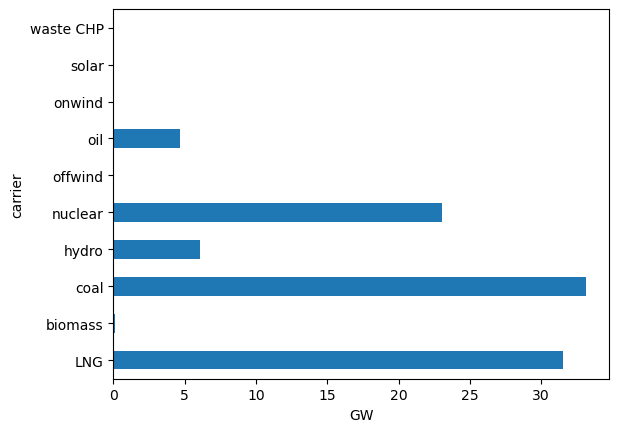

In [17]:
# add generators for technologies 

for _, row in kraftwerke.iterrows():  
        n.add(
        f"Generator",
        f" Generator {row.merge_category}, {row.primary_fuel}",  # Use row data correctly
        bus=row.merge_category,  # Make sure this column exists
        carrier=row.primary_fuel,
        p_nom=row.capacity_mw, 
        marginal_cost=calculated_costs_df.set_index('technology')['marginal_cost'].get(row.primary_fuel, None),
        )

n.generators.groupby("carrier").p_nom.sum().div(1e3).plot.barh()
plt.xlabel("GW") # zeigt nur die generatoren die nicht expandable sind 

n.generators.capital_cost
n.generators.marginal_cost.tail
print(n.generators[n.generators["carrier"] == "LNG"]["marginal_cost"])
print(row.primary_fuel)


In [18]:
print(row.primary_fuel)
print(row.primary_fuel.lower()) 

waste CHP
waste chp


In [19]:
# add lines for neigbouring countries 
# line lengths *distance *1,5
#Calculate the distances between the middle points, of neighbouring grids 
dist_7_5 = geodesic((merged_points.iloc[6].geometry.y, merged_points.iloc[6].geometry.x ), (merged_points.iloc[4].geometry.y,merged_points.iloc[4].geometry.x )).kilometers*1.5
dist_7_6 = geodesic((merged_points.iloc[6].geometry.y, merged_points.iloc[6].geometry.x ), (merged_points.iloc[5].geometry.y,merged_points.iloc[5].geometry.x )).kilometers*1.5
dist_5_6 = geodesic((merged_points.iloc[4].geometry.y, merged_points.iloc[4].geometry.x ), (merged_points.iloc[5].geometry.y,merged_points.iloc[5].geometry.x )).kilometers*1.5
dist_5_3 = geodesic((merged_points.iloc[4].geometry.y, merged_points.iloc[4].geometry.x ), (merged_points.iloc[2].geometry.y,merged_points.iloc[2].geometry.x )).kilometers*1.5
dist_5_4 = geodesic((merged_points.iloc[4].geometry.y, merged_points.iloc[4].geometry.x ), (merged_points.iloc[3].geometry.y,merged_points.iloc[3].geometry.x )).kilometers*1.5
dist_6_4 = geodesic((merged_points.iloc[5].geometry.y, merged_points.iloc[5].geometry.x ), (merged_points.iloc[3].geometry.y,merged_points.iloc[3].geometry.x )).kilometers*1.5
dist_1_3 = geodesic((merged_points.iloc[0].geometry.y, merged_points.iloc[0].geometry.x ), (merged_points.iloc[2].geometry.y,merged_points.iloc[2].geometry.x )).kilometers*1.5
dist_1_2 = geodesic((merged_points.iloc[0].geometry.y, merged_points.iloc[0].geometry.x ), (merged_points.iloc[1].geometry.y,merged_points.iloc[1].geometry.x )).kilometers*1.5
dist_2_4 = geodesic((merged_points.iloc[1].geometry.y, merged_points.iloc[1].geometry.x ), (merged_points.iloc[3].geometry.y,merged_points.iloc[3].geometry.x )).kilometers*1.5
dist_2_3 = geodesic((merged_points.iloc[1].geometry.y, merged_points.iloc[1].geometry.x ), (merged_points.iloc[2].geometry.y,merged_points.iloc[2].geometry.x )).kilometers*1.5

n.add("Link", "reg7_reg5", bus0="region_7", bus1="region_5", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_7_5, capital_cost=dist_7_5*600, marginal_cost = 0  )
n.add("Link", "reg7_reg6", bus0="region_7", bus1="region_6", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_7_6, capital_cost=dist_7_6*600, marginal_cost = 0  )
n.add("Link", "reg5_reg6", bus0="region_5", bus1="region_6", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_5_6, capital_cost=dist_5_6*600, marginal_cost = 0  )
n.add("Link", "reg5_reg3", bus0="region_5", bus1="region_3", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_5_3, capital_cost=dist_5_3*600, marginal_cost = 0  )
n.add("Link", "reg5_reg4", bus0="region_5", bus1="region_4", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_5_4, capital_cost=dist_5_4*600, marginal_cost = 0  )
n.add("Link", "reg6_reg4", bus0="region_6", bus1="region_4", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_6_4, capital_cost=dist_6_4*600, marginal_cost = 0  )
n.add("Link", "reg1_reg3", bus0="region_1", bus1="region_3", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_1_3, capital_cost=dist_1_3*600, marginal_cost = 0  )
n.add("Link", "reg1_reg2", bus0="region_1", bus1="region_2", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_1_2, capital_cost=dist_1_2*600, marginal_cost = 0  )
n.add("Link", "reg2_reg4", bus0="region_2", bus1="region_4", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_2_4, capital_cost=dist_2_4*600, marginal_cost = 0  )
n.add("Link", "reg2_reg3", bus0="region_2", bus1="region_3", p_nom_extendable=True, p_min_pu = -1,efficiency = 1,length_km=dist_2_3, capital_cost=dist_2_3*600, marginal_cost = 0  )
#length of the lines = dist *1,5 

Index(['reg2_reg3'], dtype='object')

<Axes: xlabel='snapshot', ylabel='MW'>

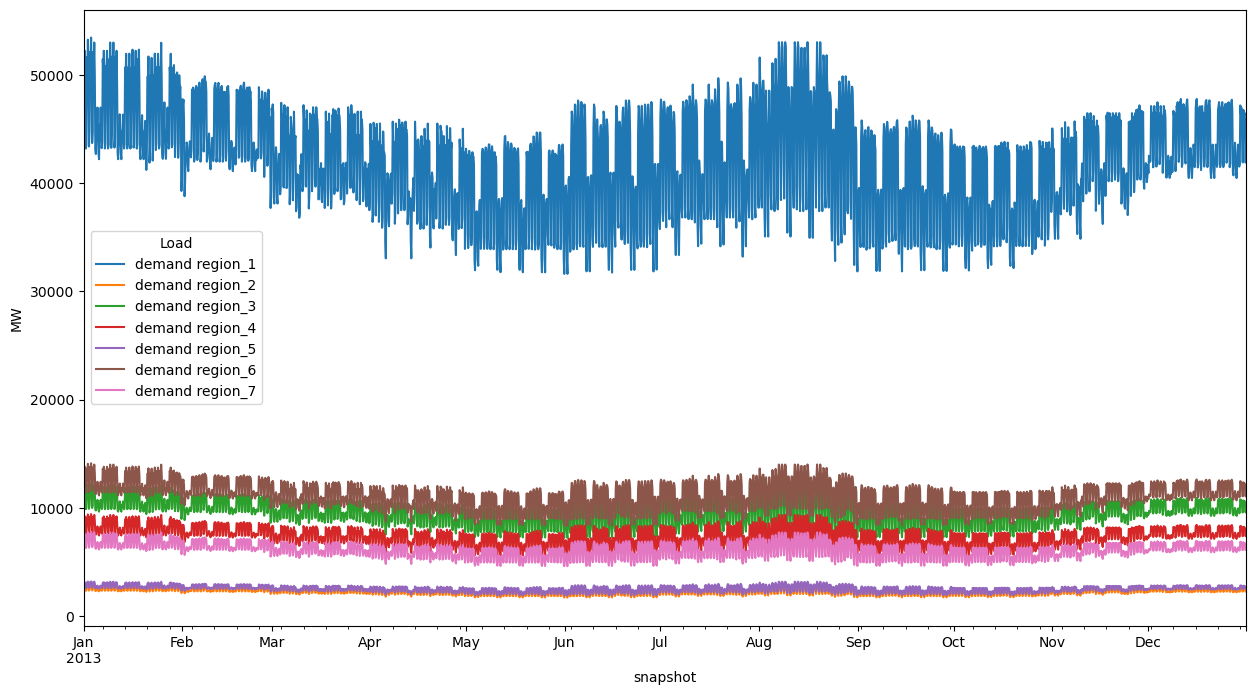

In [20]:
for region in regions:
    n.add(
        "Load",
        f"demand {region}",
    bus=region,
    p_set=load_df[region],
)
n.loads_t.p_set

n.loads_t.p_set.plot(figsize=(15, 8), ylabel="MW")

In [21]:
n.loads_t.p_set

Load,demand region_1,demand region_2,demand region_3,demand region_4,demand region_5,demand region_6,demand region_7
snapshot,,,,,,,
2013-01-01 00:00:00,50691.306163,2734.877749,11577.230408,8928.714439,3028.398138,13381.929654,7374.820961
2013-01-01 04:00:00,50303.256122,2713.941823,11488.604861,8860.363704,3005.215267,13279.488846,7318.365529
2013-01-01 08:00:00,52218.522880,2817.273555,11926.026703,9197.716818,3119.637063,13785.097538,7597.007973
2013-01-01 12:00:00,49134.913881,2650.907874,11221.770795,8654.573106,2935.416208,12971.059751,7148.389344
2013-01-01 16:00:00,43187.807169,2330.051873,9863.529513,7607.055857,2580.124379,11401.091058,6283.174960
...,...,...,...,...,...,...,...
2013-12-31 04:00:00,46214.180256,2493.329583,10554.713489,8140.118094,2760.925848,12200.019214,6723.466627
2013-12-31 08:00:00,46486.747809,2508.035042,10616.964348,8188.127862,2777.209568,12271.973955,6763.121097
2013-12-31 12:00:00,45681.342712,2464.582138,10433.020372,8046.264638,2729.093087,12059.356148,6645.946796



n.add(
    "Generator",
    "solar",
    bus="region_1",
    carrier="solar",
    capital_cost=costs.at["solar", "capital_cost"],
    marginal_cost=costs.at["solar", "marginal_cost"],
    efficiency=costs.at["solar", "efficiency"],
    p_nom_extendable=True,
    
)

<Axes: xlabel='snapshot', ylabel='CF'>

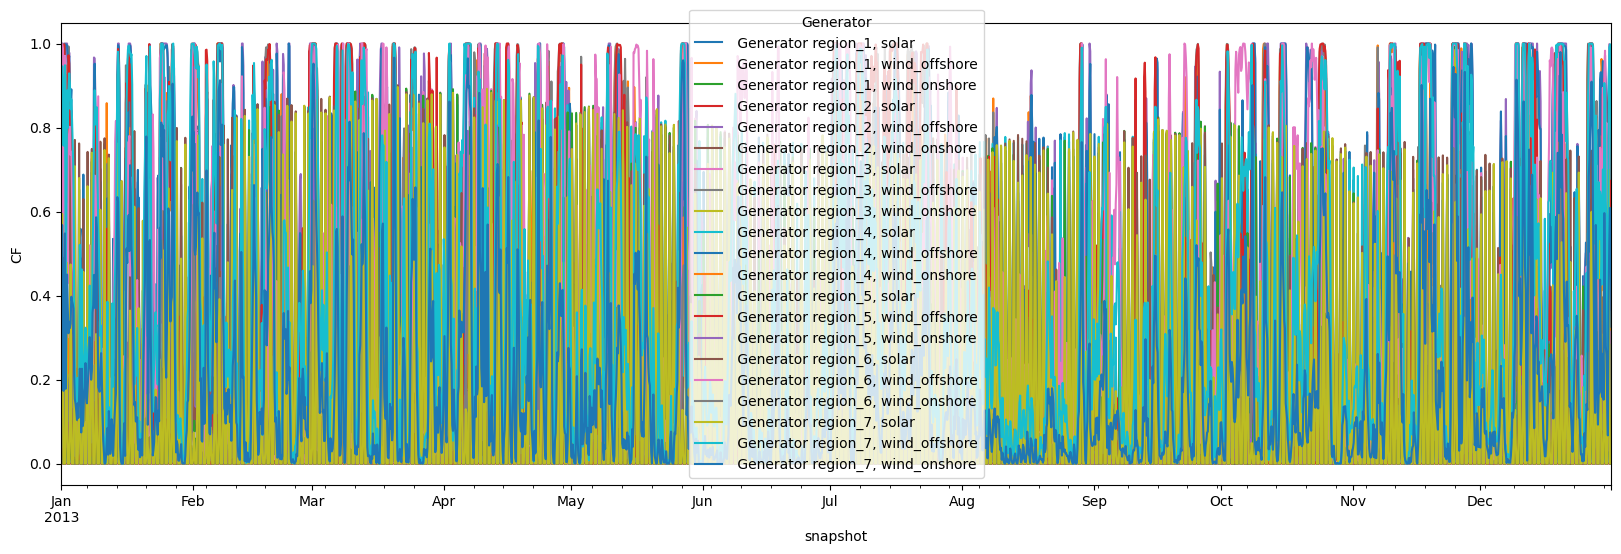

In [22]:
n.generators_t.p_max_pu.plot(figsize=(20, 6), ylabel="CF")  # extrem übersichtlich gehalten # nur für den check ob die pus drinn sind 

In [23]:
# Hinzufügen der Batterie- und Wasserstoffspeicher für jede Region

for i in range(1, 8):  # Regionen 1 bis 7
    n.add(
        "StorageUnit",
        f"battery storage region_{i}",
        bus=f"region_{i}",
        carrier="battery storage",
        max_hours=6,
        capital_cost=calculated_costs_df.loc[calculated_costs_df["technology"] == "battery inverter", "capital_cost"].values[0]
        + 6 * calculated_costs_df.loc[calculated_costs_df["technology"] == "battery storage", "capital_cost"].values[0],
        efficiency_store=calculated_costs_df.loc[calculated_costs_df["technology"] == "battery inverter", "efficiency"].values[0],   
        efficiency_dispatch=calculated_costs_df.loc[calculated_costs_df["technology"] == "battery inverter", "efficiency"].values[0],    
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

    capital_costs = (
        calculated_costs_df.loc[calculated_costs_df["technology"] == "electrolysis", "capital_cost"].values[0]
        + calculated_costs_df.loc[calculated_costs_df["technology"] == "fuel cell", "capital_cost"].values[0]
        + 300 * calculated_costs_df.loc[calculated_costs_df["technology"] == "hydrogen storage underground", "capital_cost"].values[0]
    )

    n.add(
        "StorageUnit",
        f"hydrogen storage region_{i}",
        bus=f"region_{i}",
        carrier="hydrogen storage underground",
        max_hours=300,
        capital_cost=capital_costs,
        efficiency_store=calculated_costs_df.loc[calculated_costs_df["technology"] == "electrolysis", "efficiency"].values[0],   
        efficiency_dispatch=calculated_costs_df.loc[calculated_costs_df["technology"] == "fuel cell", "efficiency"].values[0],    
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )


In [24]:
# CO2 Limit --> Keine CO2 Emissionen erlaubt --> 100% renewable
"""
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,  # Der erlaubte Gesamt-CO₂-Ausstoß (aktuell 0)
)

# Debug

#print(n.global_constraints)
#print(n.carriers[["co2_emissions"]])
#print(calculated_costs_df[["co2_intensity"]])

#for c in carriers:
#    print(f"{c}: {calculated_costs_df.loc[calculated_costs_df['technology'] == c, 'co2_intensity'].values}")
"""


'\nn.add(\n    "GlobalConstraint",\n    "CO2Limit",\n    carrier_attribute="co2_emissions",\n    sense="<=",\n    constant=0,  # Der erlaubte Gesamt-CO₂-Ausstoß (aktuell 0)\n)\n\n# Debug\n\n#print(n.global_constraints)\n#print(n.carriers[["co2_emissions"]])\n#print(calculated_costs_df[["co2_intensity"]])\n\n#for c in carriers:\n#    print(f"{c}: {calculated_costs_df.loc[calculated_costs_df[\'technology\'] == c, \'co2_intensity\'].values}")\n'

In [25]:
n.optimize(solver_name="gurobi")

c:\ProgramData\anaconda3\envs\esm-ws-24-25\Lib\site-packages\linopy\common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2532622


INFO:gurobipy:Set parameter LicenseID to value 2532622


Academic license 2532622 - for non-commercial use only - registered to m.___@campus.tu-berlin.de


INFO:gurobipy:Academic license 2532622 - for non-commercial use only - registered to m.___@campus.tu-berlin.de
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 10.58it/s]
INFO:linopy.io: Writing time: 5.34s


Read LP format model from file C:\Users\morit\AppData\Local\Temp\linopy-problem-8kgfhxkg.lp


INFO:gurobipy:Read LP format model from file C:\Users\morit\AppData\Local\Temp\linopy-problem-8kgfhxkg.lp


Reading time = 1.51 seconds


INFO:gurobipy:Reading time = 1.51 seconds


obj: 501628 rows, 227805 columns, 1083735 nonzeros


INFO:gurobipy:obj: 501628 rows, 227805 columns, 1083735 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22621.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22621.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Academic license 2532622 - for non-commercial use only - registered to m.___@campus.tu-berlin.de


INFO:gurobipy:Academic license 2532622 - for non-commercial use only - registered to m.___@campus.tu-berlin.de


Optimize a model with 501628 rows, 227805 columns and 1083735 nonzeros


INFO:gurobipy:Optimize a model with 501628 rows, 227805 columns and 1083735 nonzeros


Model fingerprint: 0xb8abea49


INFO:gurobipy:Model fingerprint: 0xb8abea49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-09, 3e+02]


INFO:gurobipy:  Matrix range     [2e-09, 3e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 1e+100]


INFO:gurobipy:  RHS range        [3e+00, 1e+100]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 304909 rows and 9142 columns


INFO:gurobipy:Presolve removed 304909 rows and 9142 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 196719 rows, 218663 columns, 677757 nonzeros


INFO:gurobipy:Presolved: 196719 rows, 218663 columns, 677757 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.21s


INFO:gurobipy:Ordering time: 0.21s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 44


INFO:gurobipy: Dense cols : 44


 AA' NZ     : 5.424e+05


INFO:gurobipy: AA' NZ     : 5.424e+05


 Factor NZ  : 3.057e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.057e+06 (roughly 200 MB of memory)


 Factor Ops : 1.033e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.033e+08 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.64202110e+13 -6.51203336e+14  3.71e+06 2.77e+03  1.17e+12     2s


INFO:gurobipy:   0   9.64202110e+13 -6.51203336e+14  3.71e+06 2.77e+03  1.17e+12     2s


   1   1.09389192e+14 -6.69166232e+14  3.15e+06 1.57e+06  1.02e+12     2s


INFO:gurobipy:   1   1.09389192e+14 -6.69166232e+14  3.15e+06 1.57e+06  1.02e+12     2s


   2   1.20663261e+14 -7.23671347e+14  2.67e+06 9.07e+05  7.42e+11     2s


INFO:gurobipy:   2   1.20663261e+14 -7.23671347e+14  2.67e+06 9.07e+05  7.42e+11     2s


   3   4.90222731e+13 -7.62426304e+14  1.52e+06 3.13e+05  3.89e+11     3s


INFO:gurobipy:   3   4.90222731e+13 -7.62426304e+14  1.52e+06 3.13e+05  3.89e+11     3s


   4   1.13576540e+13 -7.22929563e+14  2.57e+05 6.53e+04  7.40e+10     3s


INFO:gurobipy:   4   1.13576540e+13 -7.22929563e+14  2.57e+05 6.53e+04  7.40e+10     3s


   5   5.37616912e+12 -6.14175064e+14  9.73e+04 1.97e+04  2.59e+10     3s


INFO:gurobipy:   5   5.37616912e+12 -6.14175064e+14  9.73e+04 1.97e+04  2.59e+10     3s


   6   3.94898505e+12 -4.97939282e+14  6.06e+04 1.00e+04  1.50e+10     3s


INFO:gurobipy:   6   3.94898505e+12 -4.97939282e+14  6.06e+04 1.00e+04  1.50e+10     3s


   7   3.04106675e+12 -3.94896873e+14  3.83e+04 4.40e+03  8.55e+09     4s


INFO:gurobipy:   7   3.04106675e+12 -3.94896873e+14  3.83e+04 4.40e+03  8.55e+09     4s


   8   2.70758825e+12 -3.35233348e+14  3.06e+04 2.81e+03  6.39e+09     4s


INFO:gurobipy:   8   2.70758825e+12 -3.35233348e+14  3.06e+04 2.81e+03  6.39e+09     4s


   9   2.08676103e+12 -2.77533366e+14  1.67e+04 1.73e+03  3.69e+09     4s


INFO:gurobipy:   9   2.08676103e+12 -2.77533366e+14  1.67e+04 1.73e+03  3.69e+09     4s


  10   1.85778715e+12 -2.18548656e+14  1.16e+04 1.05e+03  2.44e+09     4s


INFO:gurobipy:  10   1.85778715e+12 -2.18548656e+14  1.16e+04 1.05e+03  2.44e+09     4s


  11   1.69321025e+12 -1.90000550e+14  8.03e+03 8.16e+02  1.78e+09     5s


INFO:gurobipy:  11   1.69321025e+12 -1.90000550e+14  8.03e+03 8.16e+02  1.78e+09     5s


  12   1.59131026e+12 -1.54901535e+14  6.02e+03 6.07e+02  1.31e+09     5s


INFO:gurobipy:  12   1.59131026e+12 -1.54901535e+14  6.02e+03 6.07e+02  1.31e+09     5s


  13   1.44148844e+12 -1.03150544e+14  3.36e+03 2.76e+02  7.04e+08     5s


INFO:gurobipy:  13   1.44148844e+12 -1.03150544e+14  3.36e+03 2.76e+02  7.04e+08     5s


  14   1.31126682e+12 -4.86662974e+13  1.45e+03 7.80e+01  2.71e+08     5s


INFO:gurobipy:  14   1.31126682e+12 -4.86662974e+13  1.45e+03 7.80e+01  2.71e+08     5s


  15   1.12331098e+12 -1.91285528e+13  3.37e+02 1.89e+01  7.48e+07     5s


INFO:gurobipy:  15   1.12331098e+12 -1.91285528e+13  3.37e+02 1.89e+01  7.48e+07     5s


  16   8.21221119e+11 -3.67526693e+12  1.28e+02 2.16e+00  1.60e+07     6s


INFO:gurobipy:  16   8.21221119e+11 -3.67526693e+12  1.28e+02 2.16e+00  1.60e+07     6s


  17   4.66627205e+11 -1.05255969e+12  6.11e+01 2.97e-01  5.43e+06     6s


INFO:gurobipy:  17   4.66627205e+11 -1.05255969e+12  6.11e+01 2.97e-01  5.43e+06     6s


  18   1.32222598e+11 -5.31444798e+11  9.79e+00 1.14e-01  1.69e+06     6s


INFO:gurobipy:  18   1.32222598e+11 -5.31444798e+11  9.79e+00 1.14e-01  1.69e+06     6s


  19   5.55103072e+10 -9.04911838e+10  1.71e+00 2.16e-05  3.26e+05     6s


INFO:gurobipy:  19   5.55103072e+10 -9.04911838e+10  1.71e+00 2.16e-05  3.26e+05     6s


  20   4.46835640e+10 -9.04238943e+10  1.12e+00 2.19e-05  2.97e+05     7s


INFO:gurobipy:  20   4.46835640e+10 -9.04238943e+10  1.12e+00 2.19e-05  2.97e+05     7s


  21   3.64719547e+10 -7.37970230e+10  7.90e-01 1.84e-05  2.40e+05     7s


INFO:gurobipy:  21   3.64719547e+10 -7.37970230e+10  7.90e-01 1.84e-05  2.40e+05     7s


  22   2.75771176e+10 -4.35211248e+10  4.24e-01 1.13e-05  1.53e+05     7s


INFO:gurobipy:  22   2.75771176e+10 -4.35211248e+10  4.24e-01 1.13e-05  1.53e+05     7s


  23   2.16207755e+10 -2.13040231e+10  2.58e-01 6.62e-06  9.16e+04     7s


INFO:gurobipy:  23   2.16207755e+10 -2.13040231e+10  2.58e-01 6.62e-06  9.16e+04     7s


  24   1.77116610e+10 -5.10696218e+09  1.65e-01 3.14e-06  4.85e+04     7s


INFO:gurobipy:  24   1.77116610e+10 -5.10696218e+09  1.65e-01 3.14e-06  4.85e+04     7s


  25   1.53146208e+10  3.34528119e+09  1.15e-01 1.34e-06  2.54e+04     8s


INFO:gurobipy:  25   1.53146208e+10  3.34528119e+09  1.15e-01 1.34e-06  2.54e+04     8s


  26   1.38989626e+10  5.78106451e+09  8.67e-02 7.82e-07  1.72e+04     8s


INFO:gurobipy:  26   1.38989626e+10  5.78106451e+09  8.67e-02 7.82e-07  1.72e+04     8s


  27   1.22016858e+10  6.71102659e+09  5.51e-02 5.71e-07  1.16e+04     8s


INFO:gurobipy:  27   1.22016858e+10  6.71102659e+09  5.51e-02 5.71e-07  1.16e+04     8s


  28   1.20775311e+10  6.87008694e+09  5.28e-02 5.18e-07  1.10e+04     8s


INFO:gurobipy:  28   1.20775311e+10  6.87008694e+09  5.28e-02 5.18e-07  1.10e+04     8s


  29   1.16907098e+10  7.41300583e+09  4.61e-02 4.35e-07  9.04e+03     8s


INFO:gurobipy:  29   1.16907098e+10  7.41300583e+09  4.61e-02 4.35e-07  9.04e+03     8s


  30   1.13883603e+10  7.72243785e+09  4.08e-02 3.07e-07  7.74e+03     9s


INFO:gurobipy:  30   1.13883603e+10  7.72243785e+09  4.08e-02 3.07e-07  7.74e+03     9s


  31   1.06344402e+10  7.99748322e+09  2.76e-02 2.34e-07  5.57e+03     9s


INFO:gurobipy:  31   1.06344402e+10  7.99748322e+09  2.76e-02 2.34e-07  5.57e+03     9s


  32   1.02808190e+10  8.23819567e+09  2.17e-02 1.84e-07  4.31e+03     9s


INFO:gurobipy:  32   1.02808190e+10  8.23819567e+09  2.17e-02 1.84e-07  4.31e+03     9s


  33   1.00670414e+10  8.47077270e+09  1.81e-02 1.62e-07  3.37e+03    10s


INFO:gurobipy:  33   1.00670414e+10  8.47077270e+09  1.81e-02 1.62e-07  3.37e+03    10s


  34   9.78404103e+09  8.53756622e+09  1.34e-02 1.73e-07  2.63e+03    10s


INFO:gurobipy:  34   9.78404103e+09  8.53756622e+09  1.34e-02 1.73e-07  2.63e+03    10s


  35   9.63739296e+09  8.60634942e+09  1.09e-02 1.07e-07  2.18e+03    11s


INFO:gurobipy:  35   9.63739296e+09  8.60634942e+09  1.09e-02 1.07e-07  2.18e+03    11s


  36   9.49045867e+09  8.73240106e+09  8.33e-03 6.26e-08  1.60e+03    11s


INFO:gurobipy:  36   9.49045867e+09  8.73240106e+09  8.33e-03 6.26e-08  1.60e+03    11s


  37   9.44279598e+09  8.80441848e+09  7.54e-03 5.93e-08  1.35e+03    12s


INFO:gurobipy:  37   9.44279598e+09  8.80441848e+09  7.54e-03 5.93e-08  1.35e+03    12s


  38   9.31700271e+09  8.83775066e+09  5.47e-03 7.65e-08  1.01e+03    12s


INFO:gurobipy:  38   9.31700271e+09  8.83775066e+09  5.47e-03 7.65e-08  1.01e+03    12s


  39   9.25674891e+09  8.88748480e+09  4.39e-03 8.41e-08  7.80e+02    13s


INFO:gurobipy:  39   9.25674891e+09  8.88748480e+09  4.39e-03 8.41e-08  7.80e+02    13s


  40   9.23858186e+09  8.89876079e+09  4.09e-03 3.24e-08  7.18e+02    13s


INFO:gurobipy:  40   9.23858186e+09  8.89876079e+09  4.09e-03 3.24e-08  7.18e+02    13s


  41   9.19939620e+09  8.93026846e+09  3.38e-03 1.11e-07  5.68e+02    14s


INFO:gurobipy:  41   9.19939620e+09  8.93026846e+09  3.38e-03 1.11e-07  5.68e+02    14s


  42   9.15488706e+09  8.94576210e+09  2.60e-03 7.65e-08  4.42e+02    14s


INFO:gurobipy:  42   9.15488706e+09  8.94576210e+09  2.60e-03 7.65e-08  4.42e+02    14s


  43   9.13338630e+09  8.96004121e+09  2.24e-03 1.25e-07  3.66e+02    15s


INFO:gurobipy:  43   9.13338630e+09  8.96004121e+09  2.24e-03 1.25e-07  3.66e+02    15s


  44   9.11735094e+09  8.96576567e+09  1.98e-03 5.96e-08  3.20e+02    15s


INFO:gurobipy:  44   9.11735094e+09  8.96576567e+09  1.98e-03 5.96e-08  3.20e+02    15s


  45   9.09655045e+09  8.97647113e+09  1.62e-03 9.42e-08  2.54e+02    15s


INFO:gurobipy:  45   9.09655045e+09  8.97647113e+09  1.62e-03 9.42e-08  2.54e+02    15s


  46   9.06108339e+09  8.97931503e+09  1.03e-03 1.39e-07  1.73e+02    16s


INFO:gurobipy:  46   9.06108339e+09  8.97931503e+09  1.03e-03 1.39e-07  1.73e+02    16s


  47   9.04698487e+09  8.98803022e+09  7.70e-04 1.31e-07  1.24e+02    16s


INFO:gurobipy:  47   9.04698487e+09  8.98803022e+09  7.70e-04 1.31e-07  1.24e+02    16s


  48   9.03698224e+09  8.99238801e+09  5.93e-04 8.26e-08  9.42e+01    17s


INFO:gurobipy:  48   9.03698224e+09  8.99238801e+09  5.93e-04 8.26e-08  9.42e+01    17s


  49   9.02351567e+09  8.99417533e+09  3.63e-04 8.86e-08  6.20e+01    17s


INFO:gurobipy:  49   9.02351567e+09  8.99417533e+09  3.63e-04 8.86e-08  6.20e+01    17s


  50   9.02197502e+09  8.99478098e+09  3.37e-04 3.54e-08  5.74e+01    17s


INFO:gurobipy:  50   9.02197502e+09  8.99478098e+09  3.37e-04 3.54e-08  5.74e+01    17s


  51   9.02016467e+09  8.99522981e+09  3.05e-04 6.99e-08  5.26e+01    17s


INFO:gurobipy:  51   9.02016467e+09  8.99522981e+09  3.05e-04 6.99e-08  5.26e+01    17s


  52   9.01707101e+09  8.99709302e+09  2.53e-04 3.10e-07  4.22e+01    18s


INFO:gurobipy:  52   9.01707101e+09  8.99709302e+09  2.53e-04 3.10e-07  4.22e+01    18s


  53   9.01480904e+09  8.99767695e+09  2.14e-04 1.52e-07  3.62e+01    18s


INFO:gurobipy:  53   9.01480904e+09  8.99767695e+09  2.14e-04 1.52e-07  3.62e+01    18s


  54   9.01395243e+09  8.99880452e+09  1.99e-04 2.13e-07  3.20e+01    19s


INFO:gurobipy:  54   9.01395243e+09  8.99880452e+09  1.99e-04 2.13e-07  3.20e+01    19s


  55   9.01001019e+09  8.99984991e+09  1.32e-04 1.49e-08  2.15e+01    19s


INFO:gurobipy:  55   9.01001019e+09  8.99984991e+09  1.32e-04 1.49e-08  2.15e+01    19s


  56   9.00949479e+09  8.99989811e+09  1.23e-04 1.11e-08  2.03e+01    19s


INFO:gurobipy:  56   9.00949479e+09  8.99989811e+09  1.23e-04 1.11e-08  2.03e+01    19s


  57   9.00683945e+09  9.00037983e+09  7.93e-05 2.57e-08  1.36e+01    20s


INFO:gurobipy:  57   9.00683945e+09  9.00037983e+09  7.93e-05 2.57e-08  1.36e+01    20s


  58   9.00505952e+09  9.00106328e+09  4.99e-05 3.77e-07  8.44e+00    20s


INFO:gurobipy:  58   9.00505952e+09  9.00106328e+09  4.99e-05 3.77e-07  8.44e+00    20s


  59   9.00411162e+09  9.00137532e+09  3.37e-05 1.19e-06  5.78e+00    20s


INFO:gurobipy:  59   9.00411162e+09  9.00137532e+09  3.37e-05 1.19e-06  5.78e+00    20s


  60   9.00315977e+09  9.00160765e+09  1.84e-05 5.36e-07  3.28e+00    21s


INFO:gurobipy:  60   9.00315977e+09  9.00160765e+09  1.84e-05 5.36e-07  3.28e+00    21s


  61   9.00266710e+09  9.00171839e+09  1.06e-05 3.09e-07  2.00e+00    21s


INFO:gurobipy:  61   9.00266710e+09  9.00171839e+09  1.06e-05 3.09e-07  2.00e+00    21s


  62   9.00252516e+09  9.00183830e+09  8.44e-06 2.18e-06  1.45e+00    21s


INFO:gurobipy:  62   9.00252516e+09  9.00183830e+09  8.44e-06 2.18e-06  1.45e+00    21s


  63   9.00218702e+09  9.00190043e+09  3.22e-06 2.32e-06  6.05e-01    21s


INFO:gurobipy:  63   9.00218702e+09  9.00190043e+09  3.22e-06 2.32e-06  6.05e-01    21s


  64   9.00205107e+09  9.00192392e+09  1.16e-06 1.95e-06  2.68e-01    22s


INFO:gurobipy:  64   9.00205107e+09  9.00192392e+09  1.16e-06 1.95e-06  2.68e-01    22s


  65   9.00203850e+09  9.00192891e+09  9.82e-07 1.75e-06  2.31e-01    22s


INFO:gurobipy:  65   9.00203850e+09  9.00192891e+09  9.82e-07 1.75e-06  2.31e-01    22s


  66   9.00200209e+09  9.00193867e+09  4.64e-07 1.29e-06  1.34e-01    22s


INFO:gurobipy:  66   9.00200209e+09  9.00193867e+09  4.64e-07 1.29e-06  1.34e-01    22s


  67   9.00199297e+09  9.00195316e+09  3.42e-07 6.03e-07  8.40e-02    23s


INFO:gurobipy:  67   9.00199297e+09  9.00195316e+09  3.42e-07 6.03e-07  8.40e-02    23s


  68   9.00197271e+09  9.00195753e+09  7.30e-08 2.73e-07  3.20e-02    23s


INFO:gurobipy:  68   9.00197271e+09  9.00195753e+09  7.30e-08 2.73e-07  3.20e-02    23s


  69   9.00196789e+09  9.00196032e+09  7.08e-10 1.83e-07  1.60e-02    23s


INFO:gurobipy:  69   9.00196789e+09  9.00196032e+09  7.08e-10 1.83e-07  1.60e-02    23s


  70   9.00196761e+09  9.00196375e+09  2.40e-08 1.38e-07  8.14e-03    24s


INFO:gurobipy:  70   9.00196761e+09  9.00196375e+09  2.40e-08 1.38e-07  8.14e-03    24s


  71   9.00196736e+09  9.00196607e+09  4.30e-08 3.30e-08  2.73e-03    24s


INFO:gurobipy:  71   9.00196736e+09  9.00196607e+09  4.30e-08 3.30e-08  2.73e-03    24s


  72   9.00196734e+09  9.00196640e+09  3.34e-08 6.56e-08  1.98e-03    25s


INFO:gurobipy:  72   9.00196734e+09  9.00196640e+09  3.34e-08 6.56e-08  1.98e-03    25s


  73   9.00196733e+09  9.00196698e+09  1.85e-07 3.12e-08  7.50e-04    25s


INFO:gurobipy:  73   9.00196733e+09  9.00196698e+09  1.85e-07 3.12e-08  7.50e-04    25s


  74   9.00196732e+09  9.00196732e+09  2.16e-08 9.01e-08  1.85e-05    26s


INFO:gurobipy:  74   9.00196732e+09  9.00196732e+09  2.16e-08 9.01e-08  1.85e-05    26s


  75   9.00196732e+09  9.00196732e+09  2.89e-07 2.09e-08  6.36e-08    26s


INFO:gurobipy:  75   9.00196732e+09  9.00196732e+09  2.89e-07 2.09e-08  6.36e-08    26s


  76   9.00196732e+09  9.00196732e+09  4.66e-10 5.99e-08  1.97e-12    26s


INFO:gurobipy:  76   9.00196732e+09  9.00196732e+09  4.66e-10 5.99e-08  1.97e-12    26s


INFO:gurobipy:


Barrier solved model in 76 iterations and 26.41 seconds (8.54 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 26.41 seconds (8.54 work units)


Optimal objective 9.00196732e+09


INFO:gurobipy:Optimal objective 9.00196732e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  120757 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:  120757 DPushes remaining with DInf 0.0000000e+00                27s


       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:


   15952 PPushes remaining with PInf 0.0000000e+00                27s


INFO:gurobipy:   15952 PPushes remaining with PInf 0.0000000e+00                27s


       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6123903e-09     28s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6123903e-09     28s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   90981    9.0019673e+09   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:   90981    9.0019673e+09   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:


Solved in 90981 iterations and 28.52 seconds (9.28 work units)


INFO:gurobipy:Solved in 90981 iterations and 28.52 seconds (9.28 work units)


Optimal objective  9.001967323e+09


INFO:gurobipy:Optimal objective  9.001967323e+09


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 227805 primals, 501628 duals
Objective: 9.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [26]:
print(n.model.status)
#n.objective
print(n.model.termination_condition)


ok
optimal


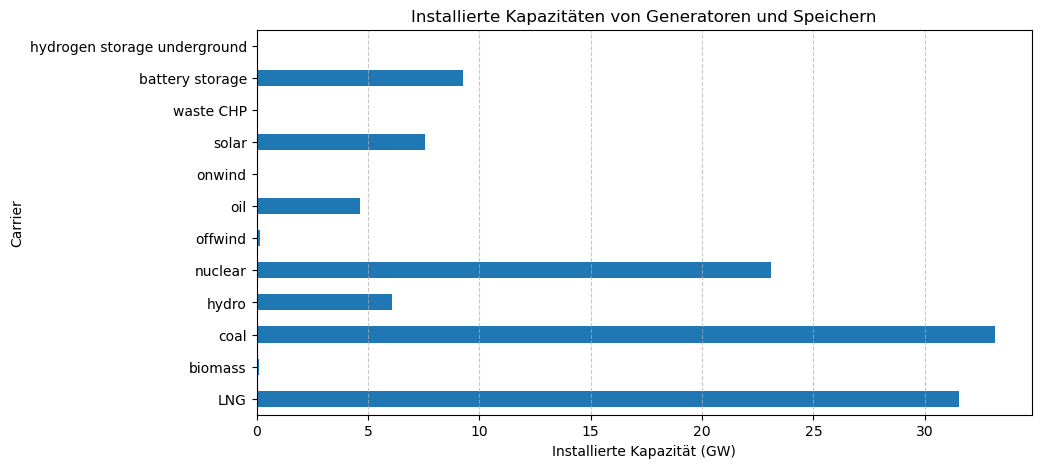

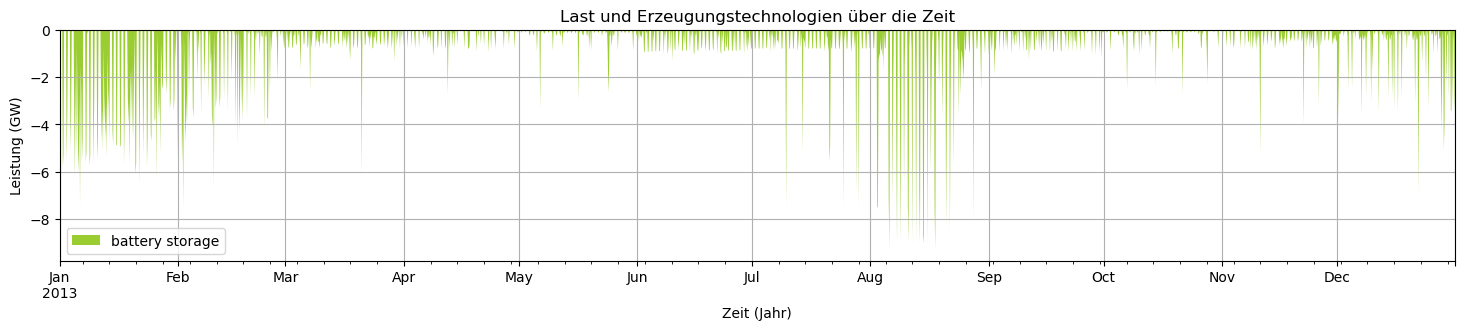

In [27]:
# Installierte Kapazitäten von Generatoren und Speichern in GW
gen_capacities = n.generators.groupby("carrier").p_nom_opt.sum().div(1e3)  # GW
storage_capacities = n.storage_units.groupby("carrier").p_nom_opt.sum().div(1e3)  # GW

# Beide zusammenführen
total_capacities = pd.concat([gen_capacities, storage_capacities])

# Balkendiagramm für installierte Kapazitäten
total_capacities.plot.barh(figsize=(10, 5))
plt.xlabel("Installierte Kapazität (GW)")
plt.ylabel("Carrier")
plt.title("Installierte Kapazitäten von Generatoren und Speichern")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Dispatch-Diagramm
p = n.statistics.energy_balance(aggregate_time=False).groupby("carrier").sum().div(1e3).drop("-", errors="ignore").T 

fig, ax = plt.subplots(figsize=(18, 3))
charge = p.where(p < 0).dropna(how="all", axis=1)
if not charge.empty:
    charge.plot.area(
        ax=ax,
        linewidth=0,
        color=charge.columns.map(n.carriers.color),
    )

# Gesamtlast hinzufügen
#n.loads_t.p_set.sum(axis=1).div(1e3).plot(ax=ax, c="k")

plt.legend()
plt.title("Last und Erzeugungstechnologien über die Zeit")
plt.xlabel("Zeit (Jahr)")
plt.ylabel("Leistung (GW)")
plt.grid()
plt.show()

In [28]:
# Auswertung / Statistik

#print(n.results)

print(n)
print(n.generators[["carrier", "p_nom_opt"]])

print("Objective Value:",n.objective / 1e9)

print("Optimized Capacities in GW:",n.generators.p_nom_opt.div(1e3))

print("Total energy generation by technology in TWh",n.snapshot_weightings.generators @ n.generators_t.p.div(1e6))

#n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot()




PyPSA Network
Components:
 - Bus: 7
 - Carrier: 16
 - Generator: 52
 - Link: 10
 - Load: 7
 - StorageUnit: 14
Snapshots: 2190
                                     carrier     p_nom_opt
Generator                                                 
Generator region_1, solar              solar   7565.295003
Generator region_1, wind_offshore    offwind    167.940873
Generator region_1, wind_onshore      onwind      0.000000
Generator region_2, solar              solar      0.000000
Generator region_2, wind_offshore    offwind      0.000000
Generator region_2, wind_onshore      onwind      0.000000
Generator region_3, solar              solar      0.000000
Generator region_3, wind_offshore    offwind      0.000000
Generator region_3, wind_onshore      onwind      0.000000
Generator region_4, solar              solar      0.000000
Generator region_4, wind_offshore    offwind      0.000000
Generator region_4, wind_onshore      onwind      0.000000
Generator region_5, solar              solar    

C:\Users\morit\AppData\Local\Temp\ipykernel_1064\1663363471.py:7: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\morit\AppData\Local\Temp\ipykernel_1064\1663363471.py:8: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



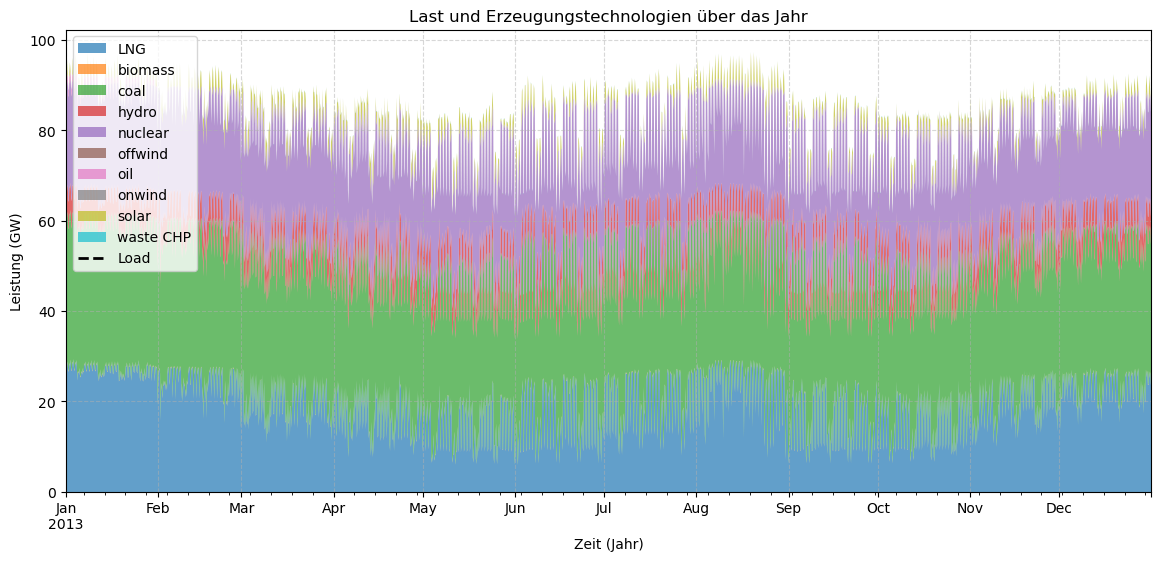

In [29]:
import matplotlib.pyplot as plt

# Prüfe, ob die Last- und Erzeugungsdaten im PyPSA-Modell verfügbar sind
if "loads_t" in dir(n) and "generators_t" in dir(n):
    # Lade die Zeitreihendaten der Last (Load) und der Erzeugung (Generators)
    load_series = n.loads_t.p_set.sum(axis=1)  # Gesamte Last im System
    generation_series = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()  # Erzeugung pro Technologie
    storage_series = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum()  # Speicherladung/-entladung

    # Konvertiere MW in GW für bessere Lesbarkeit
    load_series /= 1000
    generation_series /= 1000
    storage_series /= 1000

    # Erstelle das Diagramm
    plt.figure(figsize=(14, 6))

    # Stacked Area Plot für die Erzeugung
    generation_series.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

    # Last als schwarze Linie hinzufügen
    plt.plot(load_series, color="black", linestyle="dashed", linewidth=2, label="Load")

    # Falls Speicher vorhanden sind, als zusätzliche Layer hinzufügen
    #if not storage_series.empty:
    #    storage_series.plot.area(ax=plt.gca(), alpha=0.5, linewidth=0, cmap="coolwarm")

    # Diagramm-Formatierung
    plt.xlabel("Zeit (Jahr)")
    plt.ylabel("Leistung (GW)")
    plt.title("Last und Erzeugungstechnologien über das Jahr")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Zeige das Diagramm an
    plt.show()
else:
    print("Fehlende Daten: Die Zeitreihendaten für Last oder Erzeugung sind nicht im PyPSA-Modell verfügbar.")


In [30]:
import plotly.graph_objects as go

def plot_dispatch_plotly(n, start_date="2013-06-01", end_date="2013-06-07"):
    # Convert index to datetime if needed
    p = (
        n.statistics.energy_balance(aggregate_time=False)
        .groupby("carrier")
        .sum()
        .div(1e3)
        .drop("-")
        .T
    )
    p.index = pd.to_datetime(p.index)

    # Filter for the given date range
    p = p.loc[start_date:end_date]

    # Create a Plotly figure
    fig = go.Figure()

    # Add positive dispatch (generation)
    for carrier in p.columns:
        generation = p[carrier].where(p[carrier] > 0)
        fig.add_trace(go.Scatter(
            x=generation.index,
            y=generation,
            mode="lines",
            stackgroup="one",
            name=carrier,
            fill="tonexty",
            line=dict(width=0.5),
            marker=dict(color=n.carriers.loc[carrier, "color"])
        ))

    # Add negative dispatch (charging/storage)
    charge = p.where(p < 0).dropna(how="all", axis=1)
    for carrier in charge.columns:
        fig.add_trace(go.Scatter(
            x=charge.index,
            y=charge[carrier],
            mode="lines",
            stackgroup="two",  # Separate stack group for charging
            name=f"{carrier} (charging)",
            fill="tonexty",
            line=dict(width=0.5),
            marker=dict(color=n.carriers.loc[carrier, "color"])
        ))

    # Filter load data for the same period
    n.loads_t.p_set = n.loads_t.p_set.loc[start_date:end_date]

    # Add total load as a black line
    fig.add_trace(go.Scatter(
        x=n.loads_t.p_set.index,
        y=n.loads_t.p_set.sum(axis=1).div(1e3),
        mode="lines",
        name="Total Load",
        line=dict(color="black", width=2)
    ))

    # Customize layout
    fig.update_layout(
        title=f"Energy Dispatch from {start_date} to {end_date}",
        xaxis_title="Time",
        yaxis_title="GW",
        yaxis=dict(range=[-25, 120]),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()

# Example usage
plot_dispatch_plotly(n, start_date="2013-08-01", end_date="2013-08-31")

In [31]:
import plotly.graph_objects as go

def plot_dispatch_plotly(n, start_date="2013-06-01", end_date="2013-06-07"):
    # Convert index to datetime if needed
    p = (
        n.statistics.energy_balance(aggregate_time=False)
        .groupby("carrier")
        .sum()
        .div(1e3)
        .drop("-")
        .T
    )
    p.index = pd.to_datetime(p.index)

    # Filter for the given date range
    p = p.loc[start_date:end_date]

    # Create a Plotly figure
    fig = go.Figure()

    # Add positive dispatch (generation)
    for carrier in p.columns:
        generation = p[carrier].where(p[carrier] > 0)
        fig.add_trace(go.Scatter(
            x=generation.index,
            y=generation,
            mode="lines",
            stackgroup="one",
            name=carrier,
            fill="tonexty",
            line=dict(width=0.5),
            marker=dict(color=n.carriers.loc[carrier, "color"])
        ))

    # Add negative dispatch (charging/storage)
    charge = p.where(p < 0).dropna(how="all", axis=1)
    for carrier in charge.columns:
        fig.add_trace(go.Scatter(
            x=charge.index,
            y=charge[carrier],
            mode="lines",
            stackgroup="two",  # Separate stack group for charging
            name=f"{carrier} (charging)",
            fill="tonexty",
            line=dict(width=0.5),
            marker=dict(color=n.carriers.loc[carrier, "color"])
        ))

    # Filter load data for the same period
    n.loads_t.p_set = n.loads_t.p_set.loc[start_date:end_date]

    # Add total load as a black line
    fig.add_trace(go.Scatter(
        x=n.loads_t.p_set.index,
        y=n.loads_t.p_set.sum(axis=1).div(1e3),
        mode="lines",
        name="Total Load",
        line=dict(color="black", width=2)
    ))

    # Customize layout
    fig.update_layout(
        title=f"Energy Dispatch from {start_date} to {end_date}",
        xaxis_title="Time",
        yaxis_title="GW",
        yaxis=dict(range=[-25, 120]),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()

# Example usage
plot_dispatch_plotly(n, start_date="2013-01-01", end_date="2013-01-31")

In [32]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   LNG                   31552.90000            31552.90   
            biomass                 108.00000              108.00   
            coal                  33133.00000            33133.00   
            hydro                  6063.06000             6063.06   
            nuclear               23076.00000            23076.00   
            offwind                 167.94087                0.00   
            oil                    4655.00000             4655.00   
            solar                  7565.29500                0.00   
            waste CHP                69.12000               69.12   
Link        AC                    33280.79470                0.00   
Load        -                         0.00000                0.00   
StorageUnit battery storage        9288.43033                0.00   

                                   Supply    Withdrawal  Energy Balance  \
Generator   LNG              4.336732e+07  0.000000e+00    4.336732e+07   
            biomass          2.330970e+05  0.000000e+00    2.330970e+05   
            coal             6.815194e+07  0.000000e+00    6.815194e+07   
            hydro            1.327810e+07  0.000000e+00    1.327810e+07   
            nuclear          5.001371e+07  0.000000e+00    5.001371e+07   
            offwind          1.173454e+05  0.000000e+00    1.173454e+05   
            oil              1.849774e+05  0.000000e+00    1.849774e+05   
            solar            3.079523e+06  0.000000e+00    3.079523e+06   
            waste CHP        1.513728e+05  0.000000e+00    1.513728e+05   
Link        AC               6.999290e+07  6.999290e+07    0.000000e+00   
Load        -                0.000000e+00  1.784722e+08   -1.784722e+08   
StorageUnit battery storage  1.236856e+06  1.342075e+06   -1.052187e+05   

                             Transmission  Capacity Factor   Curtailment  \
Generator   LNG              0.000000e+00         0.627595  2.573353e+07   
            biomass          0.000000e+00         0.985528  3.423000e+03   
            coal             0.000000e+00         0.939233  4.409333e+06   
            hydro            0.000000e+00         1.000000  0.000000e+00   
            nuclear          0.000000e+00         0.989656  5.227262e+05   
            offwind          0.000000e+00         0.319055  0.000000e+00   
            oil              0.000000e+00         0.018145  1.000947e+07   
            solar            0.000000e+00         0.185872  0.000000e+00   
            waste CHP        0.000000e+00         1.000000  0.000000e+00   
Link        AC              -4.959383e+07         0.960320  0.000000e+00   
Load        -                0.000000e+00              NaN  0.000000e+00   
StorageUnit battery storage  0.000000e+00         0.126781  2.044688e+07   

                             Capital Expenditure  Operational Expenditure  \
Generator   LNG                     0.000000e+00             2.054254e+09   
            biomass                 0.000000e+00             3.689507e+06   
            coal                    0.000000e+00             2.051294e+09   
            hydro                   0.000000e+00             0.000000e+00   
            nuclear                 0.000000e+00             7.008557e+08   
            offwind                 2.616668e+07             2.487723e+03   
            oil                     0.000000e+00             2.913835e+07   
            solar                   2.958649e+08             3.264295e+04   
            waste CHP               0.000000e+00             4.090805e+06   
Link        AC                      3.390857e+09             0.000000e+00   
Load        -                       0.000000e+00             0.000000e+00   
StorageUnit battery storage         4.457208e+08             0.000000e+00   

                                  Revenue  Market Value  
Generator   LNG              8.089489e+09    186.534211  
            biomass          2.895170e+07    124

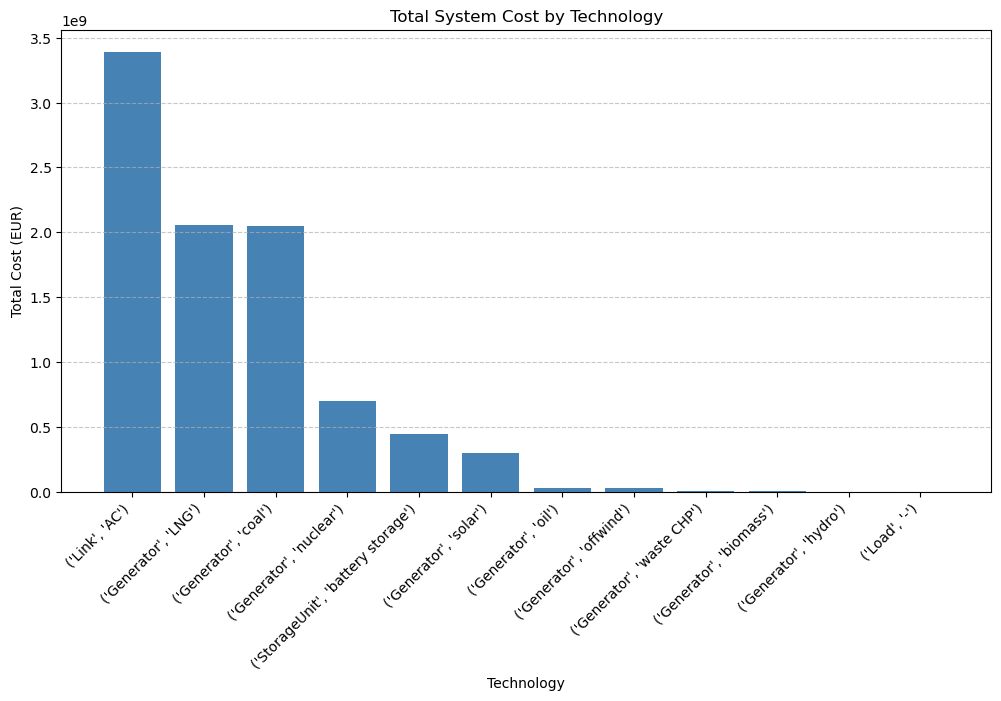

In [33]:
# Lade die Statistik-Daten direkt aus dem PyPSA-Netzwerk
stats = n.statistics()

# Extrahiere relevante Spalten
cost_data = stats[['Capital Expenditure', 'Operational Expenditure']]

# Berechne die Gesamtkosten je Technologie
total_cost = cost_data.sum(axis=1)

# Erstelle ein DataFrame für die Visualisierung
df_costs = pd.DataFrame({
    'Technology': [str(tech) for tech in total_cost.index],  # Sicherstellen, dass es Strings sind
    'Total Cost': total_cost.values
})

# Sortiere nach Kosten für eine bessere Visualisierung
df_costs = df_costs.sort_values(by='Total Cost', ascending=False)

# Visualisierung als Balkendiagramm
plt.figure(figsize=(12,6))
plt.bar(df_costs['Technology'], df_costs['Total Cost'], color='steelblue')
plt.xlabel('Technology')
plt.ylabel('Total Cost (EUR)')
plt.title('Total System Cost by Technology')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

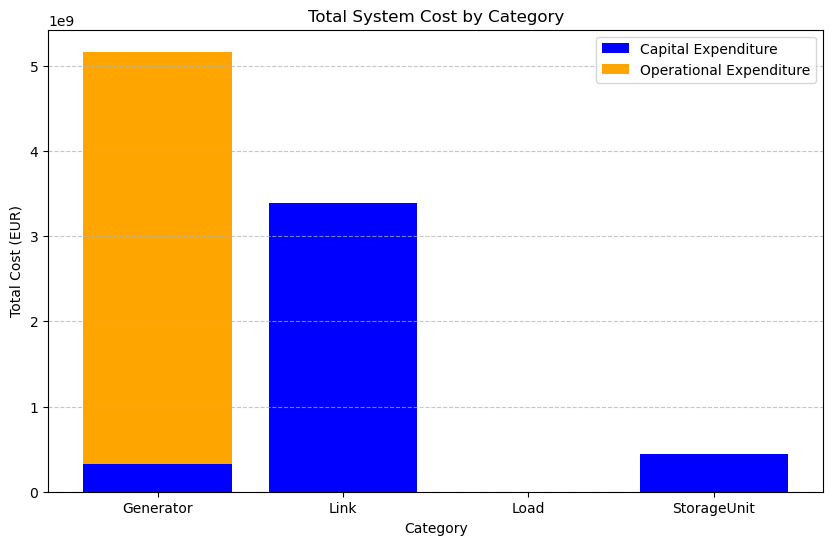

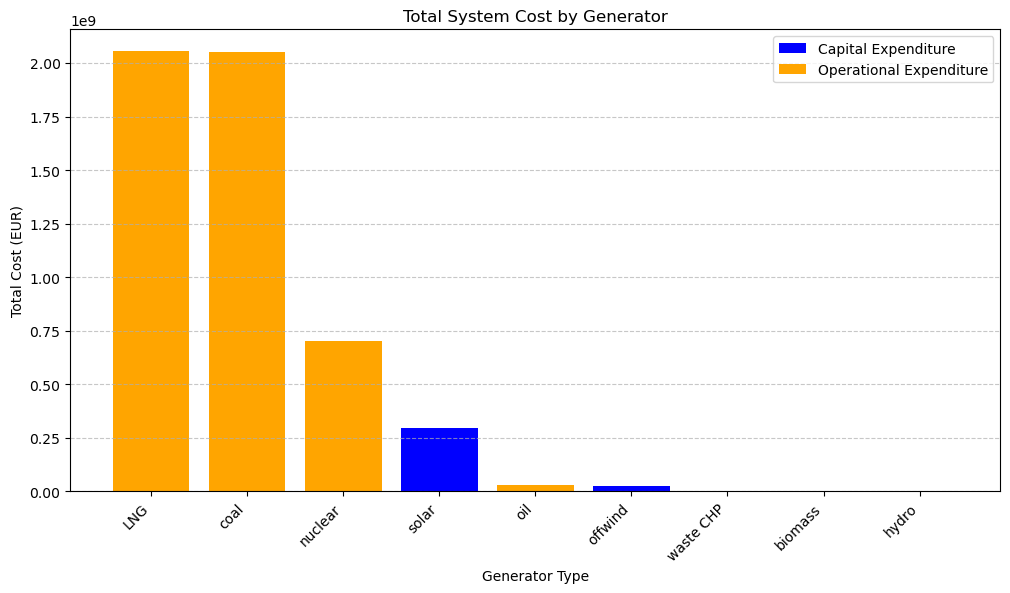

In [34]:
# Lade die Statistik-Daten direkt aus dem PyPSA-Netzwerk
stats = n.statistics()

# Extrahiere relevante Spalten
cost_data = stats[['Capital Expenditure', 'Operational Expenditure']]

# Berechne die Gesamtkosten je Technologie
total_cost = cost_data.sum(axis=1)

# Erstelle ein DataFrame für die Visualisierung
df_costs = pd.DataFrame({
    'Technology': total_cost.index.get_level_values(1),  # Stelle sicher, dass Technologie als String gespeichert wird
    'Category': total_cost.index.get_level_values(0),  # Extrahiere die Hauptkategorie (Generator, Storage, etc.)
    'Capital Expenditure': cost_data['Capital Expenditure'].values,
    'Operational Expenditure': cost_data['Operational Expenditure'].values,
    'Total Cost': total_cost.values
})

# Summiere die Gesamtkosten nach Hauptkategorie
grouped_costs = df_costs.groupby('Category')[['Capital Expenditure', 'Operational Expenditure']].sum()

# Visualisierung: Vergleich von Generatoren, Speichern und Links
plt.figure(figsize=(10,6))
bars1 = plt.bar(grouped_costs.index, grouped_costs['Capital Expenditure'], color='blue', label='Capital Expenditure')
bars2 = plt.bar(grouped_costs.index, grouped_costs['Operational Expenditure'], bottom=grouped_costs['Capital Expenditure'], color='orange', label='Operational Expenditure')
plt.xlabel('Category')
plt.ylabel('Total Cost (EUR)')
plt.title('Total System Cost by Category')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualisierung aller Generatoren einzeln
generator_df = df_costs[df_costs['Category'] == 'Generator']
generator_df = generator_df.sort_values(by='Total Cost', ascending=False)

plt.figure(figsize=(12,6))
bars1 = plt.bar(generator_df['Technology'], generator_df['Capital Expenditure'], color='blue', label='Capital Expenditure')
bars2 = plt.bar(generator_df['Technology'], generator_df['Operational Expenditure'], bottom=generator_df['Capital Expenditure'], color='orange', label='Operational Expenditure')
plt.xlabel('Generator Type')
plt.ylabel('Total Cost (EUR)')
plt.title('Total System Cost by Generator')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

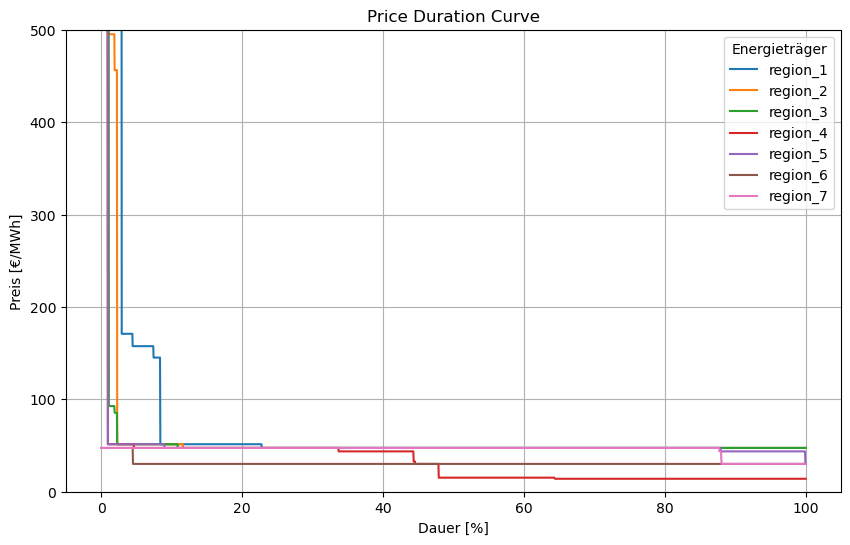

In [35]:
# 1. Lade die marginalen Preise für alle Busse aus PyPSA
df_prices = pd.DataFrame(n.buses_t.marginal_price)

# 2. Erstelle einen leeren DataFrame für die sortierten Werte
sorted_prices = pd.DataFrame()

# 3. Sortiere die Preise für jede Bus-Spalte absteigend
for column in df_prices.columns:
    sorted_prices[column] = df_prices[column].sort_values(ascending=False).reset_index(drop=True)

# 4. Prozentuale X-Achse (Dauer in %)
percentage = np.linspace(0, 100, len(sorted_prices))

# 5. Plotte die Price Duration Curves für jeden Energieträger
plt.figure(figsize=(10,6))

for column in sorted_prices.columns:
    plt.plot(percentage, sorted_prices[column], label=column)

# 6. Diagrammeinstellungen
plt.xlabel("Dauer [%]")
plt.ylabel("Preis [€/MWh]")
plt.title("Price Duration Curve")
plt.ylim(0, 500)  # Falls nötig, kannst du das Limit anpassen
plt.legend(title="Energieträger")
plt.grid()

# 7. Zeige das Diagramm an
plt.show()

C:\Users\morit\AppData\Local\Temp\ipykernel_1064\3376183513.py:7: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\morit\AppData\Local\Temp\ipykernel_1064\3376183513.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy

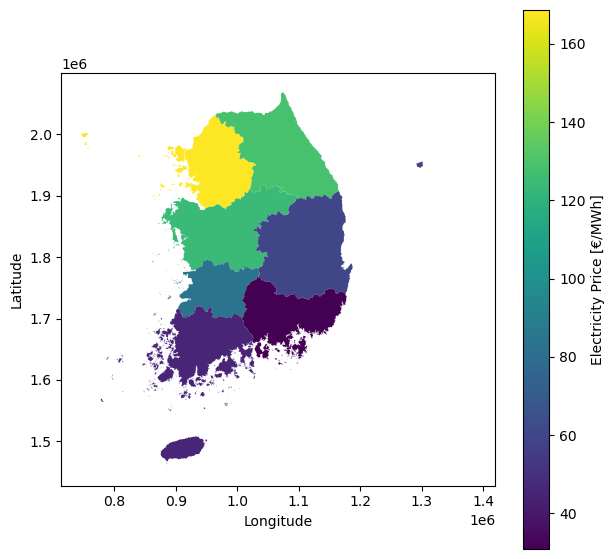

In [36]:
import cartopy
import cartopy.crs as ccrs


average_prices = n.buses_t.marginal_price.mean()
merged_gdf['average_prices']=merged_gdf.index  # zeile damit es läuft
merged_gdf['average_prices'][:]=average_prices[:]

fig, ax = plt.subplots(figsize=(7, 7))

# Ensure the GeoDataFrame is plotted correctly
merged_gdf.plot(column="average_prices",  
                legend=True, 
                legend_kwds={"label": "Electricity Price [€/MWh]", "fmt": "{:.1f} €/MWh"},
                ax=ax)

# Ensure latitude/longitude labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [37]:
#Kuchen Diagramm 

#print(n.statistics.energy_balance(aggregate_time=False).groupby("carrier").sum().drop("-").T)


import plotly.graph_objects as go

    # Sum up generation per carrier
generation = n.statistics.energy_balance(aggregate_time=False).groupby("carrier").sum().drop("-").T
    
    # Convert index to datetime
generation.index = pd.to_datetime(generation.index)

    # Filter by date range if provided

    
    # Sum over time to get total energy produced per carrier
total_generation = generation.sum().div(1e3)  # Convert to GWh
total_generation = total_generation[total_generation.index != "AC"]
    # Assign colors based on the carrier_colors dictionary
colors = [carrier_colors.get(c, "gray") for c in total_generation.index]  # Default to gray if missing

    # Create a Pie Chart
fig = go.Figure(data=[go.Pie(
    labels=total_generation.index,
    values=total_generation.values,
    marker=dict(colors=colors),
    hole=0.4,  # Donut-style pie chart
    textinfo="label+percent"
    )])

    # Layout settings
fig.update_layout(
    title="Electricity Mix",
    template="plotly_white"
)

fig.show()

carrier
offwind            0.03
solar              0.30
battery storage    0.45
AC                 3.39
LNG                2.05
biomass            0.00
coal               2.05
nuclear            0.70
oil                0.03
waste CHP          0.00
dtype: float64


<Axes: >

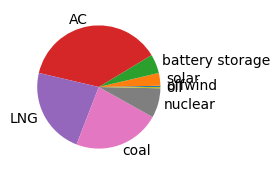

In [38]:
def system_cost(n):
    tsc = pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1)
    return tsc.sum(axis=1).droplevel(0).div(1e9).round(2)  # billion €/a
print(system_cost(n))
system_cost(n).plot.pie(figsize=(2, 2))